# 1. Texts classification (multiclass)

Тестовое задание в компанию [**Automacon**](https://automacon.ru/).

**Исходные данные:** [link](https://www.kaggle.com/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset)

**Задача:** обучить две модели классификации текстов для каждого из датасетов.

В данном ноутбуке рассмотрена работа с первым датасетом для мультиклассификации на 6 классов. Построение модели бинарной классификации для другого датасета находится во втором ноутбуке.

## Imports

In [1]:
# !pip install datasets evaluate peft

In [2]:
import gc
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from termcolor import colored
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import torch
from torch import optim
from torch.utils.data import DataLoader

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer, 
    TrainingArguments,
    TrainerCallback,
)
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from datasets import Dataset, DatasetDict
import evaluate

In [3]:
pd.set_option('display.max_colwidth', 100)

sns.set_style('whitegrid')
sns.set_palette('muted')

## Functions

In [4]:
def torch_device() -> str:
    """Вовзращает строку 'cuda' при наличии оборудования, иначе 'cpu'."""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"torch use: {colored(device, 'green', attrs=['bold'])}", 
          f"({torch.cuda.get_device_name()})"
          if torch.cuda.is_available() else "")
    return device

In [5]:
def df_info(df: pd.DataFrame):
    """Вывод первых строк таблицы pandas и количества пропусков для каждой колонки."""
    display(df.head())
    print(colored('Shape:', attrs=['bold']), df.shape, '\n')
    print(colored('Missing values:', attrs=['bold']))
    print(df.isna().sum().to_string(index=True))

In [6]:
def hist_box_chart(data: list[float | int], title: str | None = None) -> None:
    """Построение гистограммы и boxplot для списка значений."""
    fig, ax = plt.subplots(2, figsize=(11, 3.5), sharex=True, gridspec_kw={"height_ratios": (1, .15)})
    
    sns.histplot(data=data, ax=ax[0], kde=True, bins=min(150, np.unique(data).shape[0]), stat='density')
    ax[0].axvline(x=np.median(data), color='black', alpha=.5, label=f'median ({np.median(data):.2f})')
    ax[0].axvline(x=np.mean(data), color='black', alpha=.5, label=f'mean ({np.mean(data):.2f})', linestyle='dashed')
    ax[0].set(title=title, xlabel='', ylabel='')
    ax[0].legend()

    sns.boxplot(data=data, ax=ax[1], boxprops={'alpha': .5}, orient='y')
    ax[1].set(xlabel='count', ylabel='')

In [7]:
class Ansi:
    bold = '\033[1m'
    end = '\033[0m'

def get_model_size(model) -> str:
    """Вывод размера модели в миллионах параметров."""
    model_size = sum(p.numel() for p in model.parameters()) / 1e6
    model_size_train = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
    print(f"Model_size: {Ansi.bold}{model_size:.2f}{Ansi.end}M params", end='')

    if model_size_train < model_size:
        print(f" || Trainable params: {Ansi.bold}{model_size_train:.2f}{Ansi.end}M "
              f"({Ansi.bold}{model_size_train / model_size:.4%}{Ansi.end})")


def get_requires_grad(model, detail=True, only_true=False) -> str:
    """Вывод названий слоев модели для которых 'разморожены' градиенты."""
    params = {name: p.requires_grad for name, p in model.named_parameters()}
    params = pd.Series(params)

    get_model_size(model)

    print(f"\n{Ansi.bold}Requires grad:{Ansi.end}")
    print(f"True:  {Ansi.bold}{params.sum()}{Ansi.end}")
    print(f"False: {Ansi.bold}{(~params).sum()}{Ansi.end}")

    if detail:
        print()
        if only_true:
            print(params[params].to_string(index=True))
        else:
            print(params.to_string(index=True))


In [8]:
SEED = 42
DEVICE = torch_device()

torch use: cuda (AMD Radeon RX 7800 XT)


In [9]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Load data

Загружаем данные.

In [10]:
data = pd.read_csv('combined_emotion.csv')

In [11]:
df_info(data)

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last f...,sad
2,i gave up my internship with the dmrg and am feeling distraught,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughly weary of my job after having taken the universit...,fear


Shape: (422746, 2) 

Missing values:
sentence    0
emotion     0


Пропущенных значений в данных нет. Проверим наличие дубликатов.

In [12]:
print('Количество полных дубликатов:', data.duplicated().sum())
print('Количество дубликатов в столбце sentence:', data['sentence'].duplicated().sum())

Количество полных дубликатов: 6623
Количество дубликатов в столбце sentence: 28924


В данных присутствует некоторое количество дублей, причем присутствую дубликаты текстов у которых разное значение целевого признака. Вот пример:

In [13]:
data[data['sentence'] == 'when']

,sentence,emotion
28,when,anger
183069,when,sad
204577,when,fear
244470,when,joy


Это говорит о том, что разметка выполнена не идеально и в ней могут быть некоторые неточности. Но так как подобных примеров относительно размера датасета не так много, то это не должно сильно нам помешать.  

Удалим из датасета все дубликаты в столбце `sentence`.

In [14]:
data = data.drop_duplicates(subset=['sentence'])

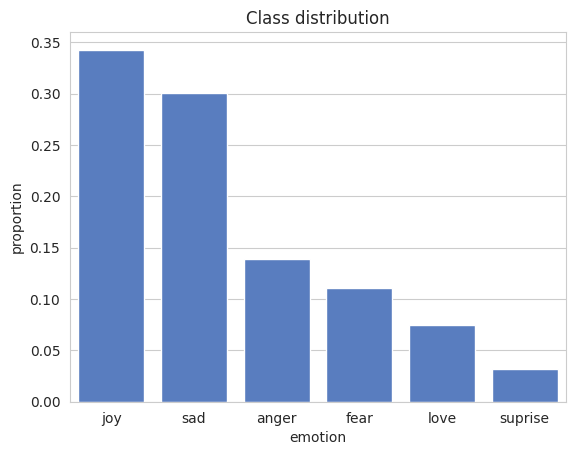

In [15]:
sns.barplot(data['emotion'].value_counts(normalize=True))
plt.title('Class distribution')
plt.show()

В датасете присутствует дисбаланс классов.

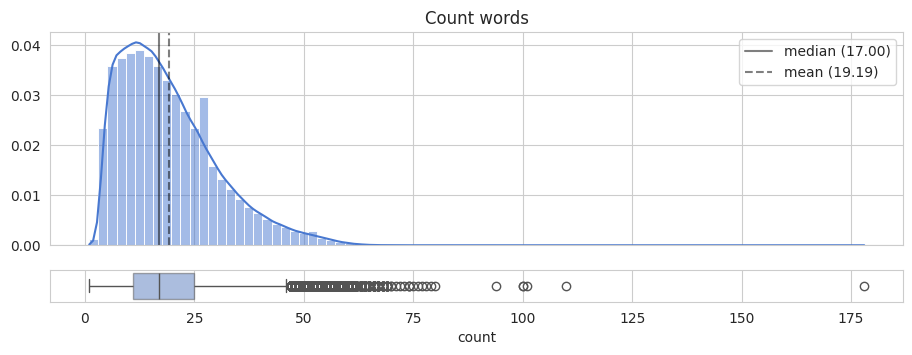

In [16]:
cnt_words = [len(text.split()) for text in data['sentence'].tolist()]

hist_box_chart(cnt_words, 'Count words')

Распределение длин текстов похоже на логнормальное, наблюдается длинный правый хвост. Средняя длина текста составляет примерно 19 слов.  

Составим словари для преобразования названия класса в индекс и обратно.

In [17]:
id2label = {k: v for k, v in enumerate(sorted(data['emotion'].unique()))}
label2id = {v: k for k, v in id2label.items()}

print(id2label)

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sad', 5: 'suprise'}


Целевой признак представим в виде числовых значений.

In [18]:
data['emotion'] = data['emotion'].apply(lambda x: label2id[x])
data = data.rename(columns={'emotion': 'label'})
data.head()

,sentence,label
0,i just feel really helpless and heavy hearted,1
1,ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last f...,4
2,i gave up my internship with the dmrg and am feeling distraught,1
3,i dont know i feel so lost,4
4,i am a kindergarten teacher and i am thoroughly weary of my job after having taken the universit...,1


## Dataset

Разделим исходный датасет на 3 выборки: train, val, test; в соотношении **80-10-10**. При разбиении применим стратификацию по таргету.

In [19]:
train_data, val_test_data = train_test_split(
    data, 
    test_size=.2, 
    shuffle=True, 
    random_state=SEED, 
    stratify=data['label']
)

val_data, test_data = train_test_split(
    val_test_data, 
    test_size=.5, 
    shuffle=True, 
    random_state=SEED, 
    stratify=val_test_data['label']
)

Для дальнейшей работы с данными воспользуемся удобной библиотекой datasets.

In [20]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_data, preserve_index=False),
    'val': Dataset.from_pandas(val_data, preserve_index=False),
    'test': Dataset.from_pandas(test_data, preserve_index=False),
})

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 315057
    })
    val: Dataset({
        features: ['sentence', 'label'],
        num_rows: 39382
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 39383
    })
})

В качестве модели возьмем [**cirimus/modernbert-base-go-emotions**](https://huggingface.co/cirimus/modernbert-base-go-emotions). Данная модель была дообучена на задачу мультилейбл классификации текстов на 28 классов по эмоциональной окраске.

В исходной модели заменим выходной слой классификации на подходящий для нашей задачи.

In [21]:
model_name = 'cirimus/modernbert-base-go-emotions'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(id2label), 
    ignore_mismatched_sizes=True, 
    problem_type="single_label_classification"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

get_model_size(model)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at cirimus/modernbert-base-go-emotions and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model_size: 149.61M params

Токенезируем тексты в датасете.

In [22]:
def tokenize_function(example):
    return tokenizer(example['sentence'], truncation=True)

dataset_tokenize = dataset.map(tokenize_function, batched=True)
dataset_tokenize = dataset_tokenize.remove_columns(['sentence'])

collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/315057 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/39382 [00:00<?, ? examples/s]

Map:   0%|          | 0/39383 [00:00<?, ? examples/s]

## Train

Для того, что бы ускорить адаптацию модели под наши данные а так же снизить эффект катастрофического забывания, воспользуемся таким методом PEFT, как LoRA.

In [23]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    target_modules=['attn.Wqkv'],
    lora_dropout=.1,
    bias='none', 
)

model_lora = get_peft_model(model, peft_config)

Обучать будем только выходной классификационный слой и адаптеры LoRA, поэтому заморозим градиенты на всех остальных слоях.

In [24]:
model_lora.requires_grad_(False)
model_lora.classifier.requires_grad_(True)
for name, param in model_lora.named_parameters():
    if "lora" in name:
        param.requires_grad = True

get_requires_grad(model_lora, only_true=True)

Model_size: 150.15M params || Trainable params: 0.55M (0.3662%)

Requires grad:
True:  48
False: 136

base_model.model.model.layers.0.attn.Wqkv.lora_A.default.weight     True
base_model.model.model.layers.0.attn.Wqkv.lora_B.default.weight     True
base_model.model.model.layers.1.attn.Wqkv.lora_A.default.weight     True
base_model.model.model.layers.1.attn.Wqkv.lora_B.default.weight     True
base_model.model.model.layers.2.attn.Wqkv.lora_A.default.weight     True
base_model.model.model.layers.2.attn.Wqkv.lora_B.default.weight     True
base_model.model.model.layers.3.attn.Wqkv.lora_A.default.weight     True
base_model.model.model.layers.3.attn.Wqkv.lora_B.default.weight     True
base_model.model.model.layers.4.attn.Wqkv.lora_A.default.weight     True
base_model.model.model.layers.4.attn.Wqkv.lora_B.default.weight     True
base_model.model.model.layers.5.attn.Wqkv.lora_A.default.weight     True
base_model.model.model.layers.5.attn.Wqkv.lora_B.default.weight     True
base_model.model.model

Во время обучения будем отслеживать метрику `accuracy`.

In [25]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Так как стандартный Trainer из transformers при использовании PEFT делает чекпоинты только весов самих адаптеров, то определим callback, который позволит сохранять веса так же и для классификационной головы.

In [26]:
class SaveClassifierWeightsCallback(TrainerCallback):
    def on_save(self, args, state, control, model=None, **kwargs):
        """Сохраняем веса слоя классификации после каждого сохранения чекпоинта."""

        checkpoint_dir = Path(args.output_dir) / f'checkpoint-{state.global_step}'
        # Если директория {checkpoint_dir} еще не создана! Пропускаем сохранение.
        if not checkpoint_dir.exists():
            return

        classifier_layer = model.base_model.model.classifier  # Достаем слой классификации
        save_path = checkpoint_dir / 'classifier_weights.pt'

        torch.save(classifier_layer.state_dict(), save_path)

Для классификационного слоя будем использовать более высокий learning rate для ускорения адаптации, так как веса в данном слое были инициализированы случайными значениями.

In [27]:
params_group = [
    {'params': [param for param in model_lora.model.model.parameters() if param.requires_grad],
    'lr': 5e-5},

    {'params': model_lora.classifier.parameters(),
    'lr': 5e-4}
]
optimizer = optim.AdamW(params_group, weight_decay=.01)

Эффективный размер батча для обучения возьмем в 128 (64 * 2) элементов. Используем косинусный шедулер для плавного снижения скорости обучения. Количество эпох возьмем равным 3.

In [28]:
training_args = TrainingArguments(
    output_dir="./multiclass",
    overwrite_output_dir=True,
    save_total_limit=3,
    eval_strategy="steps",
    save_strategy="steps",
    save_safetensors=False,
    logging_steps=1,
    eval_steps=.1,
    save_steps=.1,
    lr_scheduler_type='cosine',
    warmup_steps=30,
    fp16=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=SEED,
)

trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=dataset_tokenize["train"],
    eval_dataset=dataset_tokenize["val"],
    data_collator=collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
    callbacks=[SaveClassifierWeightsCallback()],
)

In [29]:
gc.collect()
torch.cuda.empty_cache()

trainer.train()

/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)
/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/transformers/models/modernbert/modeling_modernbert.py:436: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  F.scaled_dot_product_attention(


Step,Training Loss,Validation Loss,Accuracy
739,0.659500,0.239904,0.919532
1478,0.213700,0.125895,0.952186
2217,0.160500,0.098212,0.957392
2956,0.108300,0.091816,0.959728
3695,0.264400,0.080623,0.961861
4434,0.140900,0.074636,0.962242
5173,0.237800,0.071976,0.963080
5912,0.167300,0.070570,0.963029
6651,0.092700,0.069403,0.963791


TrainOutput(global_step=7383, training_loss=0.27043643793184274, metrics={'train_runtime': 2338.7231, 'train_samples_per_second': 404.14, 'train_steps_per_second': 3.157, 'total_flos': 3.608509812451128e+16, 'train_loss': 0.27043643793184274, 'epoch': 2.9989843591306116})

Видим, что валидационный loss на всем протяжении обучения плавно снижался. Метрика Accuracy на валидации так же почти на всех итерациях снижалась, что говорит об отсутствии переобучения. Loss на тренировке прыгал, так как мы итерировались по шагам а не по эпохам.

## Test

Перейдем к тестированию полученной модели.

Для начала определим вспомогательные функции для получения предсказаний и значений метрик.

In [29]:
def get_predict(model, dataloader, device):
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='predictions'):
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            pred = torch.argmax(logits, dim=1).cpu()
            predictions.append(pred)

    return torch.cat(predictions)

In [30]:
def get_metrics(ground_truth, predictions, title: str):
    print(colored(title.upper().center(60, '-'), 'light_blue', attrs=['bold']))
    print(classification_report(ground_truth, 
                                predictions, 
                                digits=4, 
                                target_names=list(label2id.keys())
                                ))

    _, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(
        ground_truth, 
        predictions, 
        ax=ax, 
        cmap='Blues', 
        colorbar=False, 
        display_labels=list(label2id.keys())
    )
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

Подгрузим последнюю модель из сохраненного чекпоинта.

In [31]:
model_lora = PeftModel.from_pretrained(model, './multiclass/checkpoint-7383')

load_state_cls = torch.load(
    'multiclass/checkpoint-7383/classifier_weights.pt', 
    map_location=DEVICE, 
    weights_only=True
)

model_lora.base_model.model.classifier.load_state_dict(load_state_cls)


<All keys matched successfully>

Сделаем 2 даталоудера для возможности итерации по батчам.

In [32]:
gt_val = dataset_tokenize['val']['label']
gt_test = dataset_tokenize['test']['label']

val_dataset = dataset_tokenize['val'].remove_columns('label')
test_dataset = dataset_tokenize['test'].remove_columns('label')

val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64, collate_fn=collator)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, collate_fn=collator)

Сделаем предсказания для валидационной и тестовой выборок.

In [33]:
pred_val = get_predict(model_lora, val_loader, DEVICE)
pred_test = get_predict(model_lora, test_loader, DEVICE)

predictions:   0%|          | 0/616 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)
/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/transformers/models/modernbert/modeling_modernbert.py:436: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  F.scaled_dot_product_attention(


predictions:   0%|          | 0/616 [00:00<?, ?it/s]

Для начала взглянем на результаты для валидационного датасета.

---------------------VALIDATION DATASET---------------------
              precision    recall  f1-score   support

       anger     0.9654    0.9639    0.9646      5478
        fear     0.9367    0.9393    0.9380      4363
         joy     0.9755    0.9713    0.9734     13503
        love     0.9055    0.9199    0.9126      2947
         sad     0.9827    0.9845    0.9836     11851
     suprise     0.8802    0.8710    0.8756      1240

    accuracy                         0.9637     39382
   macro avg     0.9410    0.9416    0.9413     39382
weighted avg     0.9637    0.9637    0.9637     39382



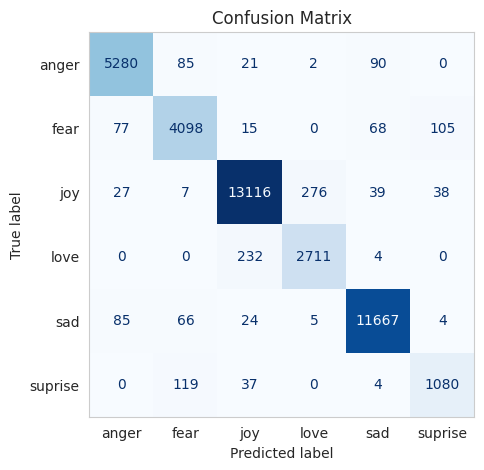

In [34]:
get_metrics(gt_val, pred_val, 'validation dataset')

На валидации получаем метрику `accuracy` **0.9637**.  
Видно, что для самого малочисленного класса `suprise` получилась самая низкая точность, что неудивительно, так как мы никак не учитывали дисбаланс классов. Но в целом, значение `f1` в **0.88** для самого малочисленного класса - это довольно неплохо. Для мажорных классов получили метрику `f1` в **0.97-0.98**.

Теперь протестируем модель на отложенной тестовой выборке.

------------------------TEST DATASET------------------------
              precision    recall  f1-score   support

       anger     0.9626    0.9591    0.9609      5478
        fear     0.9356    0.9388    0.9372      4363
         joy     0.9757    0.9696    0.9727     13503
        love     0.9020    0.9243    0.9130      2947
         sad     0.9810    0.9828    0.9819     11851
     suprise     0.8745    0.8703    0.8724      1241

    accuracy                         0.9622     39383
   macro avg     0.9386    0.9408    0.9397     39383
weighted avg     0.9623    0.9622    0.9622     39383



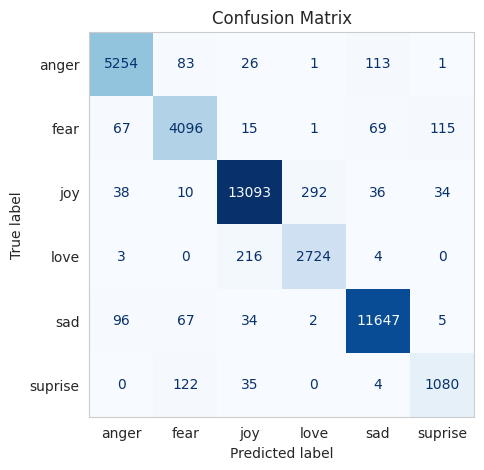

In [35]:
get_metrics(gt_test, pred_test, 'test dataset')

По сравнению с валидационной выборкой метрики на тесте практически не изменились, что говорит о том, что модель не переобучилась и в целом имеет довольно неплохую обобщающую способность.
Итоговая точность `accuracy` составила **0.9622**.

Анализируя матрицу ошибок можно сделать вывод, что наиболее часто модель путает между собой метки `joy` и `love` - это логично, так как эти эмоции имеют схожий эмоциональный окрас и могут содержать пересекающиеся характеристики.  
Так же класс `surprise` чаще всего путается с `fear` - вероятно, это связано с тем, что удивление может проявляться схожим образом с испугом.

**Возможные улучшения:**
- Учесть дисбаланс классов с помощью одного из следующих методов, либо их комбинации:
    - семплирование данных
    - установить большие веса в оптимизаторе для минорных классов
    - использовать аугментации для минорных классов, например через обратный перевод (back translation)
- Протестировать большее число предобученных моделей, возможно удастся найти лучший вариант.
- Экспериментировать с параметрами обучения и PEFT. Т.к. датасет довольно большой можно попробовать обучать всю модель целиком, без использования адаптеров, используя разный lr для слоев на разной глубине. Но обучение в таком случае потребует больше вычислительных ресурсов.